#Imports

In [ ]:
from google.colab.patches import cv2_imshow
import math
import sys, time
import cv2
import numpy as np
import glob
import os

In [ ]:
import pandas as pd

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (3,054 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
from PIL import Image
import pytesseract

#Utility functions for plate recognition

In [ ]:
def ratioCheck(area, width, height):
    ratio = float(width) / float(height)
    if ratio < 1:
        ratio = 1 / ratio
    if (area < 1063.62 or area > 73862.5) or (ratio < 3 or ratio > 6):
        return False
    return True

In [ ]:
def isMaxWhite(plate):
    avg = np.mean(plate)
    if(avg>=115):
        return True
    else:
         return False

In [ ]:
def ratio_and_rotation(rect):
    (x, y), (width, height), rect_angle = rect
    if(width>height):
        angle = -rect_angle
    else:
        angle = 90 + rect_angle

    if angle>15:
         return False

    if height == 0 or width == 0:
        return False

    area = height*width
    if not ratioCheck(area,width,height):
        return False
    else:
        return True

In [ ]:
def clean2_plate(plate):
    gray_img = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray_img, 110, 255, cv2.THRESH_BINARY)
    if cv2.waitKey(0) & 0xff == ord('q'):
        pass
    num_contours,hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if num_contours:
        contour_area = [cv2.contourArea(c) for c in num_contours]
        max_cntr_index = np.argmax(contour_area)

        max_cnt = num_contours[max_cntr_index]
        max_cntArea = contour_area[max_cntr_index]
        x,y,w,h = cv2.boundingRect(max_cnt)

        if not ratioCheck(max_cntArea,w,h):
            return plate,None

        final_img = thresh[y:y+h, x:x+w]
        return final_img,[x,y,w,h]

    else:
        return plate, None

#Importing Dataset

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.getcwd()

'/content'

In [ ]:
os.chdir("/content/drive/MyDrive/DIP dataset")
images = os.listdir()

#Preprocessing techniques

##Image interpolation

In [ ]:
for index in images:
  img = cv2.imread(index,cv2.IMREAD_COLOR)
  print("\n\n\n\n\n\n\n\nOriginal image:\n")
  cv2_imshow(img)
  scale_percent = 200
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
  
  img2 = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)
  print("\nInterpolated image:\n")
  cv2_imshow(img2)

This cell output is too large and can only be displayed while logged in.


##Original image to gaussian blur

In [ ]:
for index in images:
  img = cv2.imread(index,cv2.IMREAD_COLOR)
  img2 = cv2.GaussianBlur(img, (3,3), 0)
  res = np.hstack((img, img2))
  cv2_imshow(res)
  print("\n\n\n\n")

This cell output is too large and can only be displayed while logged in.


##Grayscale

In [ ]:
for index in images:
  img = cv2.imread(index,cv2.IMREAD_COLOR)
  img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img2 = np.stack((img2,)*3, axis=-1)
  res = np.hstack((img, img2))
  cv2_imshow(res)
  print("\n\n\n\n")

This cell output is too large and can only be displayed while logged in.


##Grayscale to Histogram equalized image

In [ ]:
for index in images:
  img = cv2.imread(index,cv2.IMREAD_COLOR)
  img2 = cv2.GaussianBlur(img, (3,3), 0)
  img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  heq = cv2.equalizeHist(img2)
  res = np.hstack((img2, heq))
  cv2_imshow(res)
  print("\n\n\n\n")

This cell output is too large and can only be displayed while logged in.


##Grayscale to Threshold

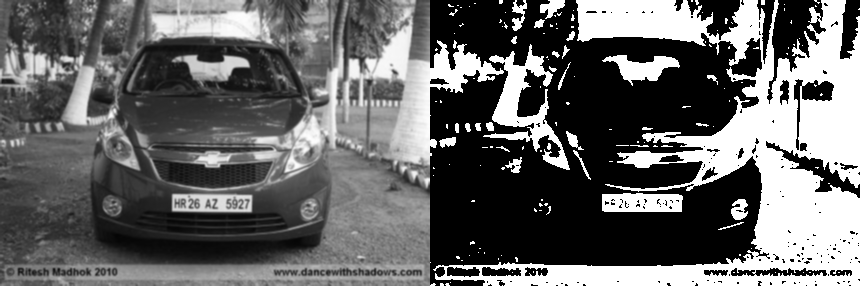

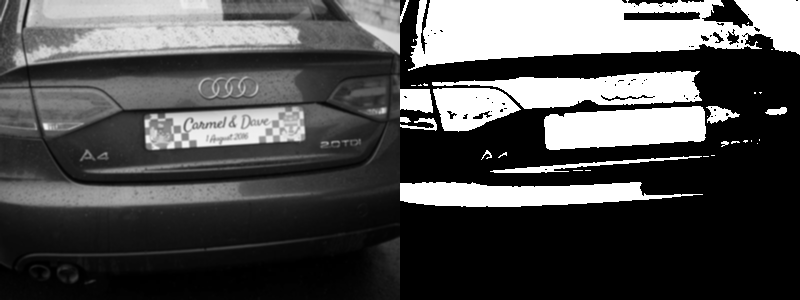

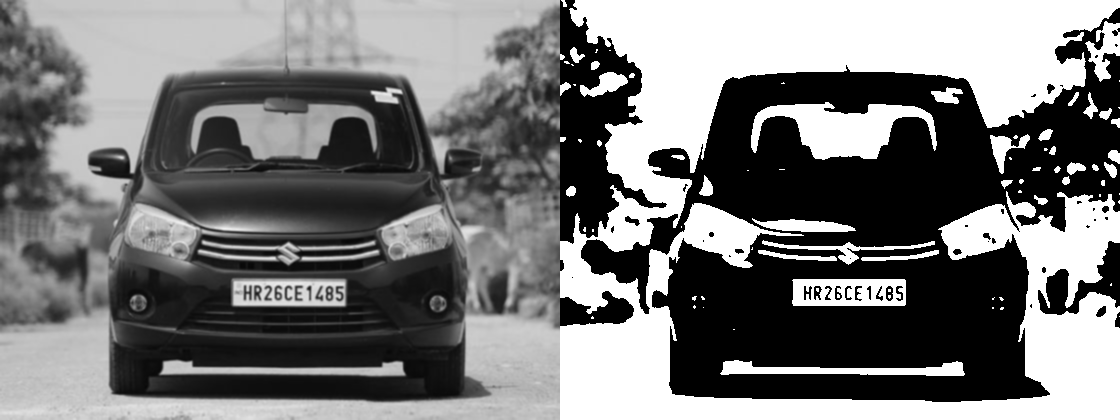

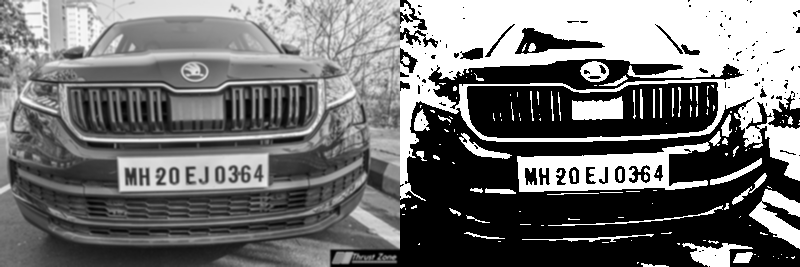

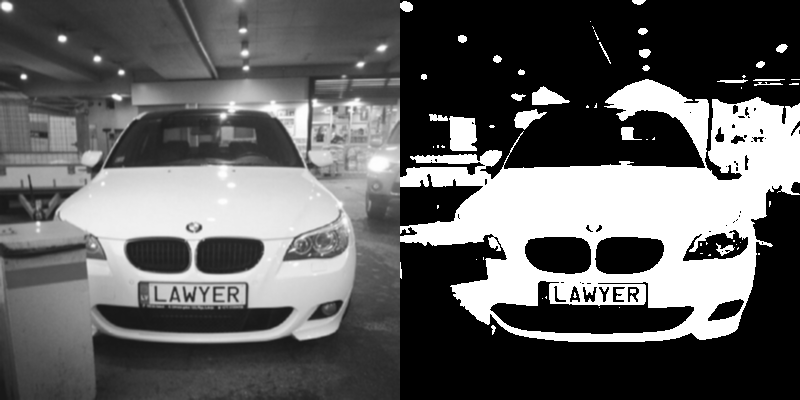

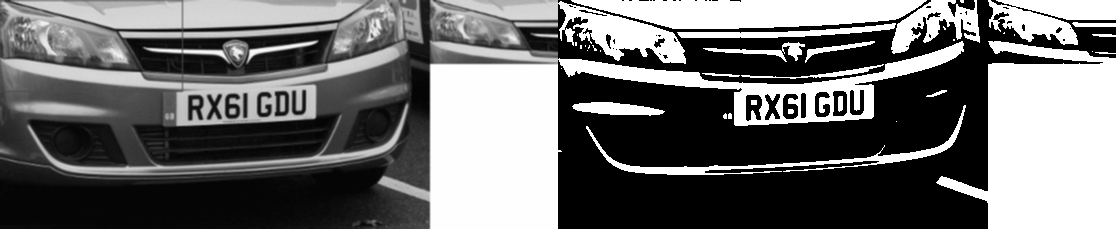

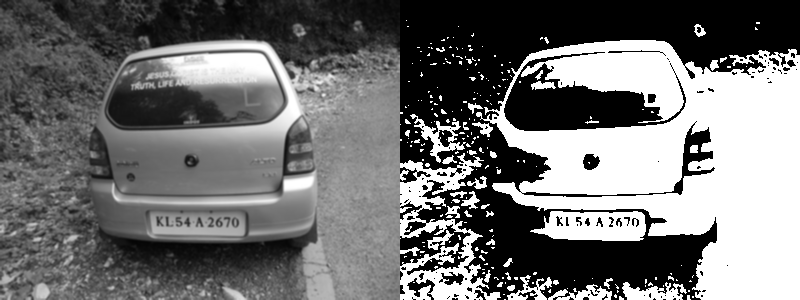

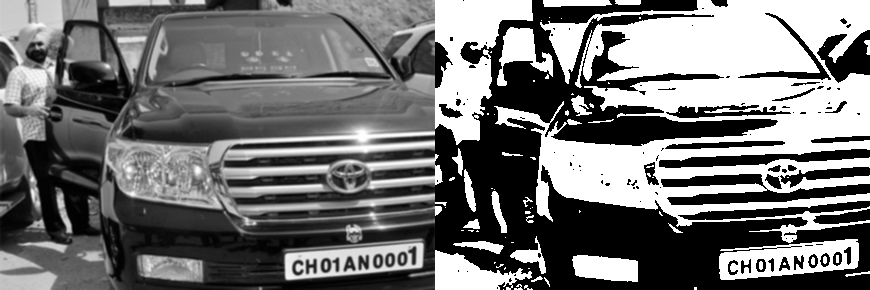

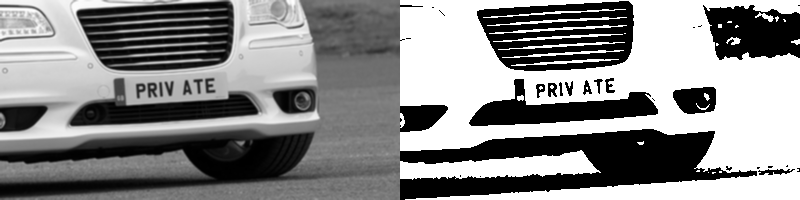

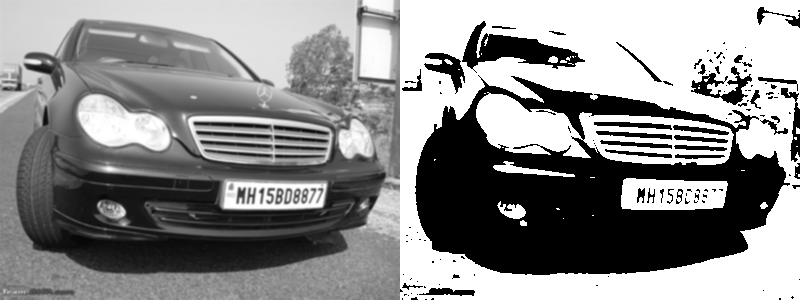

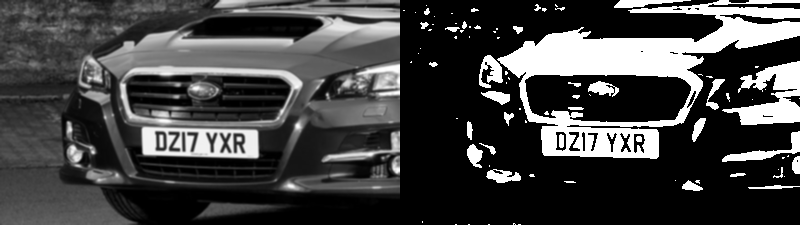

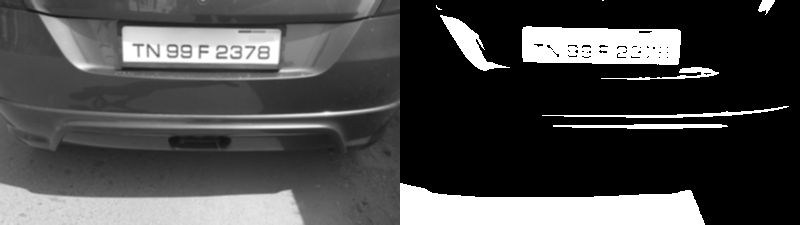

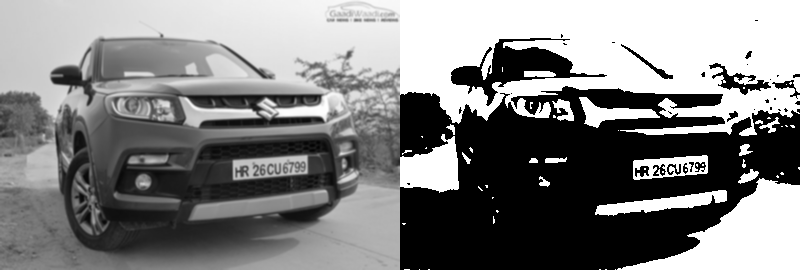

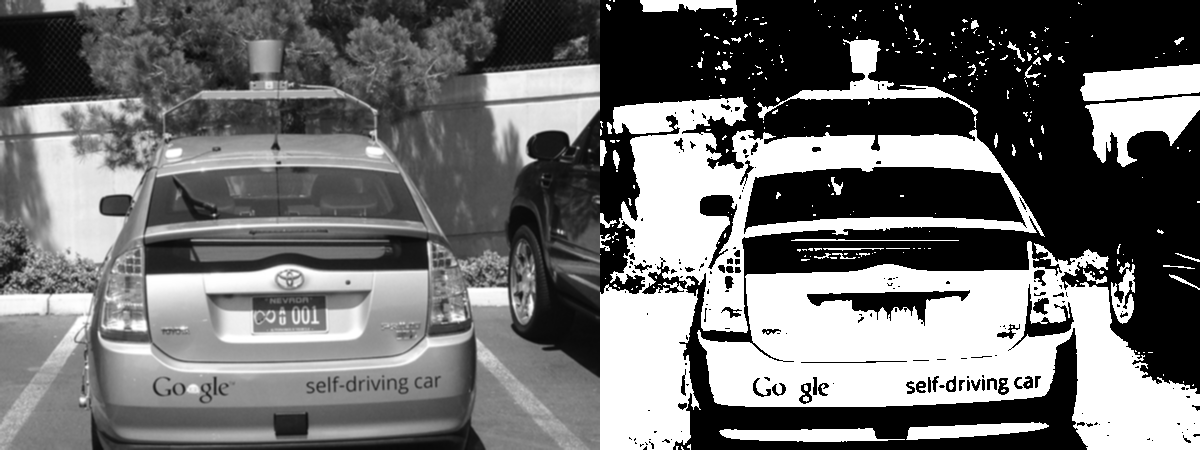

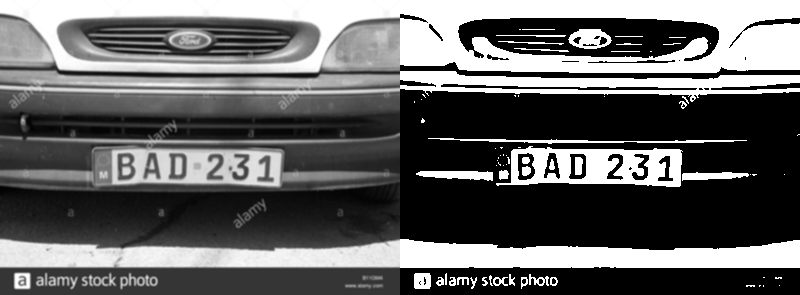

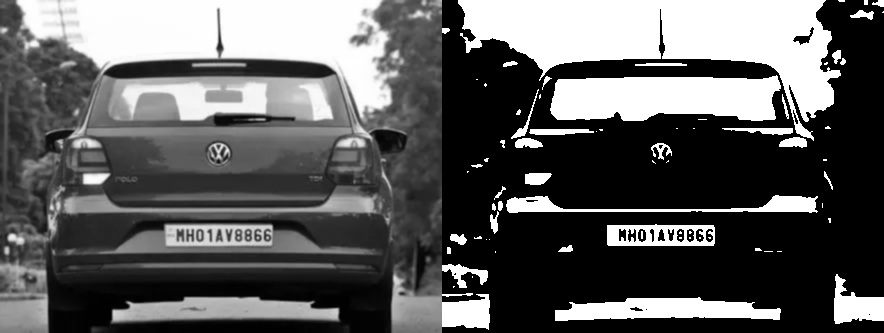

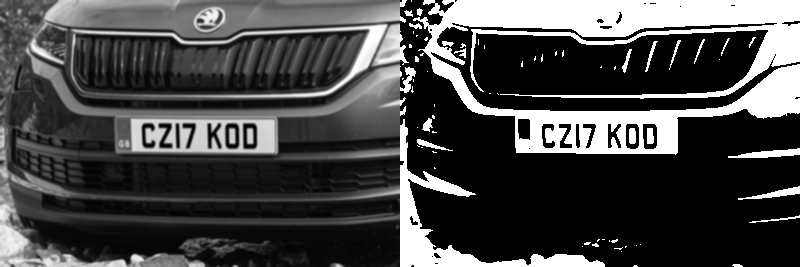

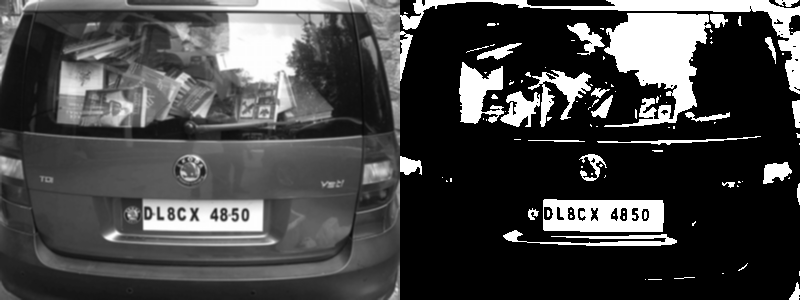

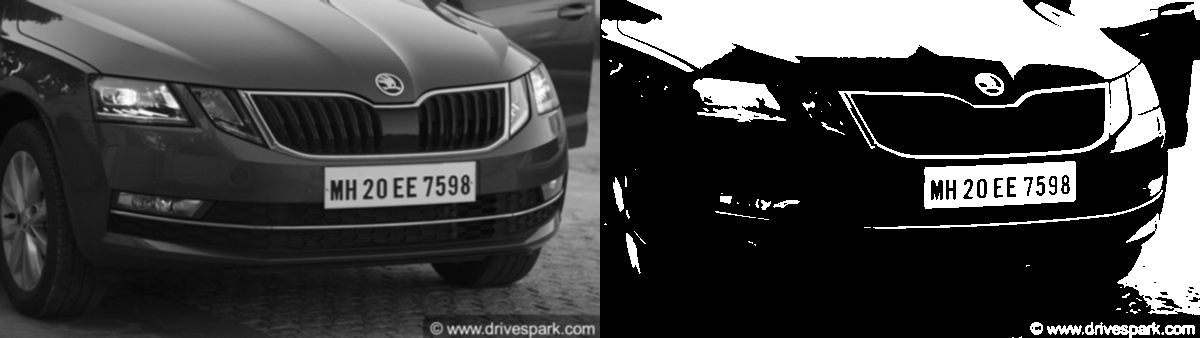

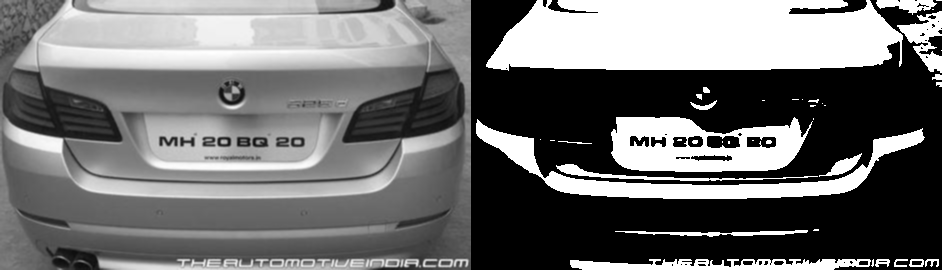

In [ ]:
for index in images:
  img = cv2.imread(index,cv2.IMREAD_COLOR)
  img2 = cv2.GaussianBlur(img, (3,3), 0)
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  _,img3 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  res = np.hstack((img2, img3))
  cv2_imshow(res)
  print("\n\n\n\n")

#License plate detection and recognition

In [ ]:
l={}
list_license_plates=[] 
predicted_license_plates = []
for index in images:
  list_license_plates.append(index)
  f=0
  img = cv2.imread(index,cv2.IMREAD_COLOR)
  print("Input image...",)
  cv2_imshow(img)
  text = None
  if cv2.waitKey(0) & 0xff == ord('q'):
      pass
  scale_percent = 200 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
  
  img2 = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  img2 = cv2.GaussianBlur(img, (3,3), 0)
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  heq = cv2.equalizeHist(img2)
  img2 = cv2.Sobel(img2,cv2.CV_8U,1,0,ksize=3)
  _,img2 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  element = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(17, 3))
  morph_img_threshold = img2.copy()
  cv2.morphologyEx(src=img2, op=cv2.MORPH_CLOSE, kernel=element, dst=morph_img_threshold)
  num_contours, hierarchy= cv2.findContours(morph_img_threshold,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
  for i,cnt in enumerate(num_contours):

      min_rect = cv2.minAreaRect(cnt)
      if ratio_and_rotation(min_rect) and f==0:
          x,y,w,h = cv2.boundingRect(cnt)
          plate_img = img[y:y+h,x:x+w]
          print("Identified number plate...")
          cv2_imshow(plate_img)
          f=1
          cv2.imwrite("/content/plate_im.png",plate_img)
          if cv2.waitKey(0) & 0xff == ord('q'):
              pass

          if(isMaxWhite(plate_img)):
              clean_plate, rect = clean2_plate(plate_img)
              if rect:
                  x1,y1,w1,h1 = rect
                  x,y,w,h = x+x1,y+y1,w1,h1
                  text = pytesseract.image_to_string(Image.open('/content/plate_im.png'))
                  for ch in text:
                    if not ch.isalnum() or ch==" " or ch=="\n" or ch=="\x0c":
                      text = text.replace(ch,"")
                  print("Detected Plate Text :",text)
                  l[index]=text
                  predicted_license_plates.append(text)
list_license_plates = [s[:-4] for s in list_license_plates]

This cell output is too large and can only be displayed while logged in.


#Accuracy

In [ ]:
def minDis(s1, s2, n, m, dp) :
           
  if(n == 0) :
      return m        
  if(m == 0) :
      return n
                     
  if(dp[n][m] != -1)  :
      return dp[n][m];
                    
  if(s1[n - 1] == s2[m - 1]) :           
    if(dp[n - 1][m - 1] == -1) : 
        dp[n][m] = minDis(s1, s2, n - 1, m - 1, dp)
        return dp[n][m]                   
    else :
        dp[n][m] = dp[n - 1][m - 1]
        return dp[n][m]
                   
  else :            
    if(dp[n - 1][m] != -1) :   
      m1 = dp[n - 1][m]      
    else :
      m1 = minDis(s1, s2, n - 1, m, dp)
               
    if(dp[n][m - 1] != -1) :                
      m2 = dp[n][m - 1]            
    else :
      m2 = minDis(s1, s2, n, m - 1, dp)   
    if(dp[n - 1][m - 1] != -1) :    
      m3 = dp[n - 1][m - 1]    
    else :
      m3 = minDis(s1, s2, n - 1, m - 1, dp)
      
    dp[n][m] = 1 + min(m1, min(m2, m3))
    return dp[n][m]

In [ ]:
print("Actual License Plate".rjust(30), "Predicted License Plate".rjust(30), "Accuracy".rjust(30))
print("--------------------".rjust(30), "-----------------------".rjust(30), "--------".rjust(30))
dl=[]
max = 0
for x in range(len(list_license_plates)):
  str1 = list_license_plates[x]
  str2 = predicted_license_plates[x]
  n = len(str1)
  m = len(str2)
  dp = [[-1 for i in range(m + 1)] for j in range(n + 1)]
  dl.append(minDis(str1,str2,n,m,dp))
  if dl[x]>max:
    max = dl[x]
li = []
for i in range(len(dl)):
  li.append([list_license_plates[i],predicted_license_plates[i],100*(1-(dl[i]/max))])
  print(list_license_plates[i].rjust(30),predicted_license_plates[i].rjust(30),str(round(100*(1-(dl[i]/max)),2)).rjust(30),"%",sep="")


          Actual License Plate        Predicted License Plate                       Accuracy
          --------------------        -----------------------                       --------
                    HR26AZ5927                   1HR26AZ5927                         90.91%
                   Carmel&Dave                  4EftCarmeloe                         27.27%
                    HR26CE1485                    HR26CE1485                         100.0%
                    MH20EJ0364                    MH20EJ0364                         100.0%
                        LAWYER                        LAWYER                         100.0%
                       RX61GDU                      NRX6IGDU                         81.82%
                     KL54A2670                    KL5442670f                         81.82%
                    CH01AN0001                    cHO1ANO001                         72.73%
                       PRIVATE                       PRIVATE                  